# Titanic Ship Wreck
Author: *Kamau Wa Wainaina*

Helpful Notebooks: *Gunes Evitan*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
path = "../../../Data/titanic/"
train = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")

In [4]:
train = train.set_index("PassengerId")
test = test.set_index("PassengerId")

## Missing Values

While filling missing values, it's best to use the entire dataset to avoid overfitting to either the train or test data.

In [7]:
df_all = pd.concat([train, test])
df_all.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB


In [9]:
cat_attributes = ["Name", "Sex", "Ticket", "Cabin", "Embarked"]
num_attributes = ["Pclass", "Age", "SibSp", "Parch", "Fare"]

The following columns have null values **Age**, **Fare**, **Embarked**, and **Cabin**. 

### Age.

20% of the values in both train and test are missing values for the age column. We could use the mean to replace missing values. However, we could be a bit clever and use highly correlated columns to help in this endevour.

In [13]:
corr_matrix = df_all[num_attributes].corr()
corr_matrix["Age"].sort_values(ascending=False)

Age       1.000000
Fare      0.178740
Parch    -0.150917
SibSp    -0.243699
Pclass   -0.408106
Name: Age, dtype: float64

The highest correlation is with passenger class which is a negative correlation. We can use this column to help fill the null values in age. Before we start that, let's check if sex ages within the different passenger classes was the same and if not sex will also be used to calculate mean age. 

In [15]:
for pclass in df_all["Pclass"].unique():
    female_mean = np.floor(df_all[(df_all["Pclass"]==pclass) & (df_all["Sex"]=="female")]["Age"].mean())
    male_mean = np.floor(df_all[(df_all["Pclass"]==pclass) & (df_all["Sex"]=="male")]["Age"].mean())
    
    print(f"In passenger class {pclass}, the mean age of females was {female_mean} whereas for males was {male_mean}.")

In passenger class 3, the mean age of females was 22.0 whereas for males was 25.0.
In passenger class 1, the mean age of females was 37.0 whereas for males was 41.0.
In passenger class 2, the mean age of females was 27.0 whereas for males was 30.0.


Males were generally older across the different passenger classes.

In [17]:
df_all["Age"] = df_all.groupby(["Sex", "Pclass"])["Age"].transform(lambda x: x.fillna(np.floor(x.mean())))

### Fare.

Only one passenger (Storey, Mr. Thomas) doesn't have value for fare.

In [20]:
df_all[pd.isnull(df_all["Fare"])]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


Since there is only one null, we can try to be as precise as possible while guessing what this value might have being.

In [22]:
replace_value = df_all[(df_all["Pclass"]==3)&
                   (df_all["Sex"]=="male")&
                   (df_all["SibSp"]==0)&
                   (df_all["Parch"]==0)&
                   (df_all["Embarked"]=="S")&
                   (df_all["Age"]>=60)]["Fare"].mean()
df_all["Fare"] = df_all["Fare"].fillna(replace_value)

### Embarked.

In [24]:
df_all[pd.isnull(df_all["Embarked"])]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


These people have the same ticket suggesting that they travelled together and therefore embarked from the same location. From the Gunes Evitan's notebook, using a simple google search, he found that both passengers, embarked from Southampton. Miss. Amelie was Mrs. George Maid. (I confirmed this information with a Google search of my own.)

In [26]:
df_all["Embarked"] = df_all["Embarked"].fillna("S")

### Cabin.

We extract the first letter of cabin and replace null values with M.

In [29]:
df_all["Deck"] = df_all["Cabin"].transform(lambda x: x[0] if pd.notnull(x) else "M")
df_all.drop("Cabin", axis=1, inplace=True)

Here we replace nulls with M because it's hard to use other features to help with replacement. Also, we extract we extract the first letter of the Cabin column as this represents the deck each passenger was on (again Gunes Evitan's notebook to the rescue). 

In [31]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1309 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1309 non-null   float64
 9   Embarked  1309 non-null   object 
 10  Deck      1309 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB


We see that the only column with nulls is survived which is our target column.

In [33]:
train = df_all.loc[train.index]
test = df_all.loc[test.index]

del df_all

## EDA

### Visualizing Deck column.

Let's start by viewing passenger class distribution in each deck.

In [37]:
decks_ = ["A", "B", "C", "D", "E", "F", "G", "T", "M"]

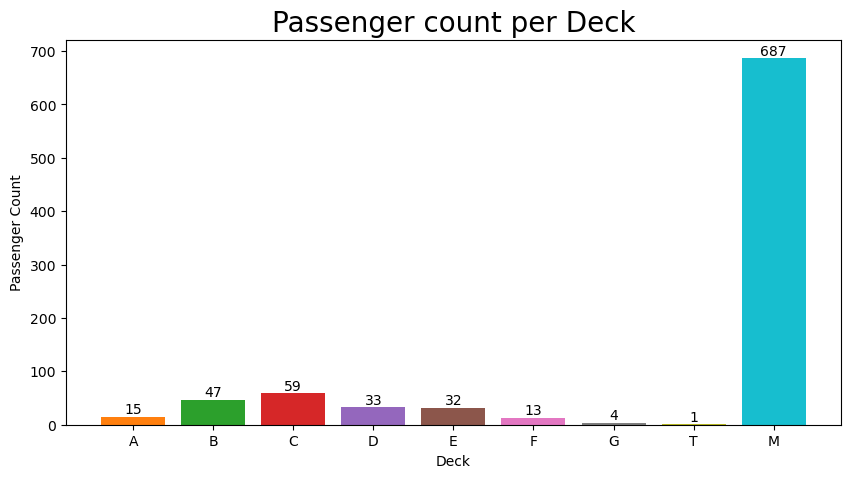

In [38]:
deck_population = []
for deck in decks_:
    population = train[train["Deck"]==deck]["Survived"].count()
    deck_population.append(population)
    
fig, ax = plt.subplots(figsize=(10,5))
rect = ax.bar(decks_, deck_population, color=["C1","C2", "C3", "C4","C5", "C6","C7","C8", "C9"])
ax.bar_label(rect)
ax.set_title("Passenger count per Deck",size=20)
ax.set_xlabel("Deck")
ax.set_ylabel("Passenger Count")
plt.show()

In [39]:
deck_dist = np.zeros((9, 3))

# We fill the matrix with the passenger distributions.
for i in range(len(decks_)):
    pclass_total = train[train["Deck"]==decks_[i]]["Pclass"].count()
    pclass_dist = train[train["Deck"]==decks_[i]].groupby("Pclass")["Pclass"].count()
    for pclass, pclass_count in pclass_dist.items():
        deck_dist[i, pclass-1] = pclass_count/pclass_total

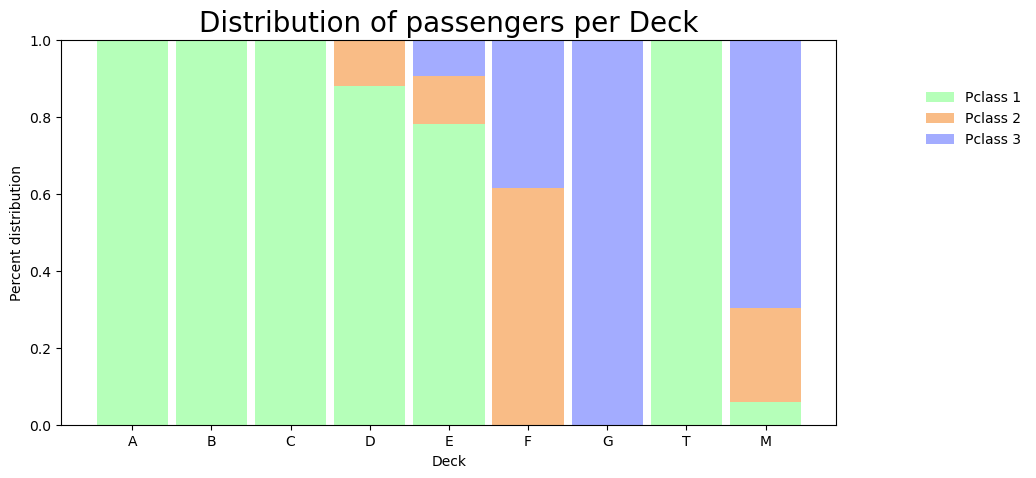

In [40]:
fig, ax = plt.subplots(figsize=(10,5))

width = 0.9
ax.bar(decks_, deck_dist[:, 0], color='#b5ffb9', width=width, label="Pclass 1")
ax.bar(decks_, deck_dist[:, 1], bottom=deck_dist[:, 0], color='#f9bc86', width=width, label="Pclass 2")
ax.bar(decks_, deck_dist[:, 2], bottom=deck_dist[:, 0] + deck_dist[:, 1], color='#a3acff', width=width, label="Pclass 3")
ax.legend(loc="upper left", bbox_to_anchor=(1.1, 0.9), frameon=False)
ax.set_title("Distribution of passengers per Deck", size=20)
ax.set_xlabel("Deck")
ax.set_ylabel("Percent distribution")

plt.show()

In [41]:
deck_survival = np.zeros((9, 2))

for i in range(len(decks_)):
    total_passenger_deck = train[train["Deck"]==decks_[i]]["Survived"].count()
    survived_deck = train[train["Deck"]==decks_[i]]["Survived"].sum() # Because we're counting number of 1.
    died_deck = train[(train["Deck"]==decks_[i])&(train["Survived"]==0)]["Survived"].count()
    deck_survival[i, 0] = survived_deck/total_passenger_deck
    deck_survival[i, 1] = died_deck/total_passenger_deck

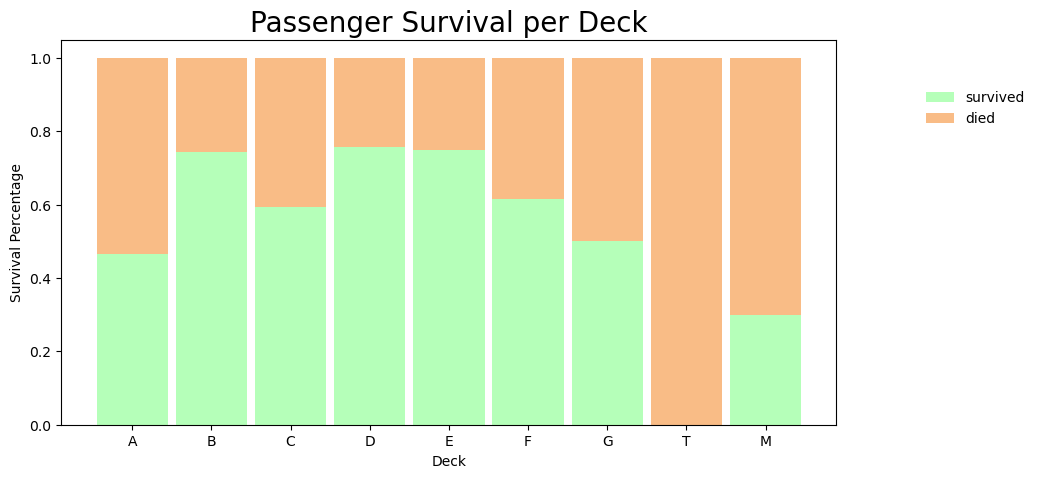

In [42]:
fig, ax = plt.subplots(figsize=(10, 5))

width = 0.9
ax.bar(decks_, deck_survival[:, 0], color='#b5ffb9', width=width, label="survived")
ax.bar(decks_, deck_survival[:, 1], color='#f9bc86', bottom=deck_survival[:,0], width=width, label="died")
ax.legend(loc="upper left", bbox_to_anchor=(1.1, 0.9), frameon=False)
ax.set_title("Passenger Survival per Deck", size=20)
ax.set_xlabel("Deck")
ax.set_ylabel("Survival Percentage")
plt.show()

### Visualizing Continous Variables.

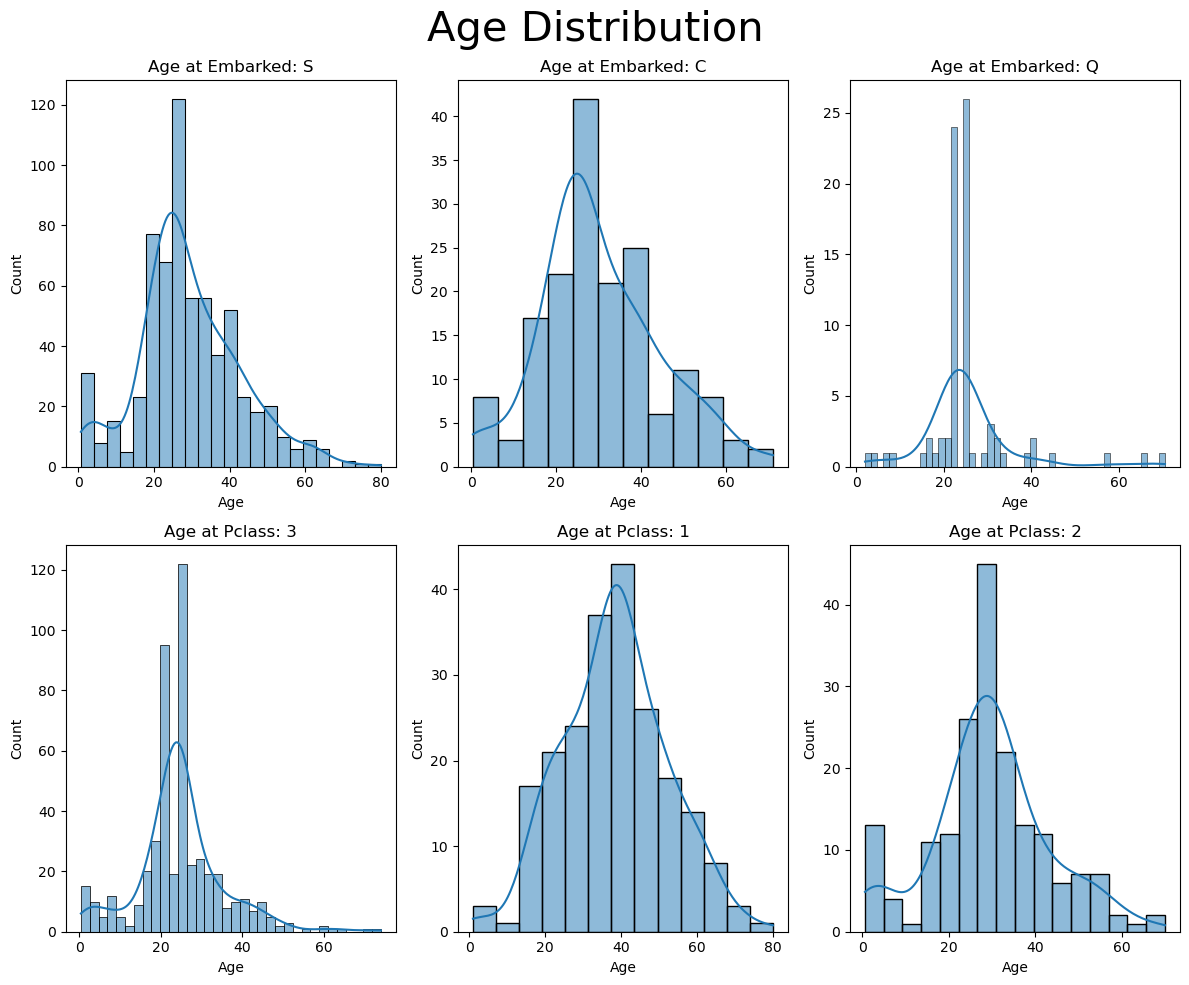

In [107]:
fig, ax = plt.subplots(2,3, figsize=(12,10))

embarked = train["Embarked"].unique()
pclass = train["Pclass"].unique()

for i in range(2):
    for j in range(3):
        if i == 0:
            data = train[train["Embarked"]==embarked[j]]
            sns.histplot(data=data, x="Age", ax=ax[i,j], kde=True)
            ax[i, j].set_title(f"Age at Embarked: {embarked[j]}")
        else:
            data = train[train["Pclass"]==pclass[j]]
            sns.histplot(data=data, x="Age", ax=ax[i,j], kde=True)  
            ax[i, j].set_title(f"Age at Pclass: {pclass[j]}")
fig.suptitle("Age Distribution", size=30)
fig.tight_layout()
plt.show()

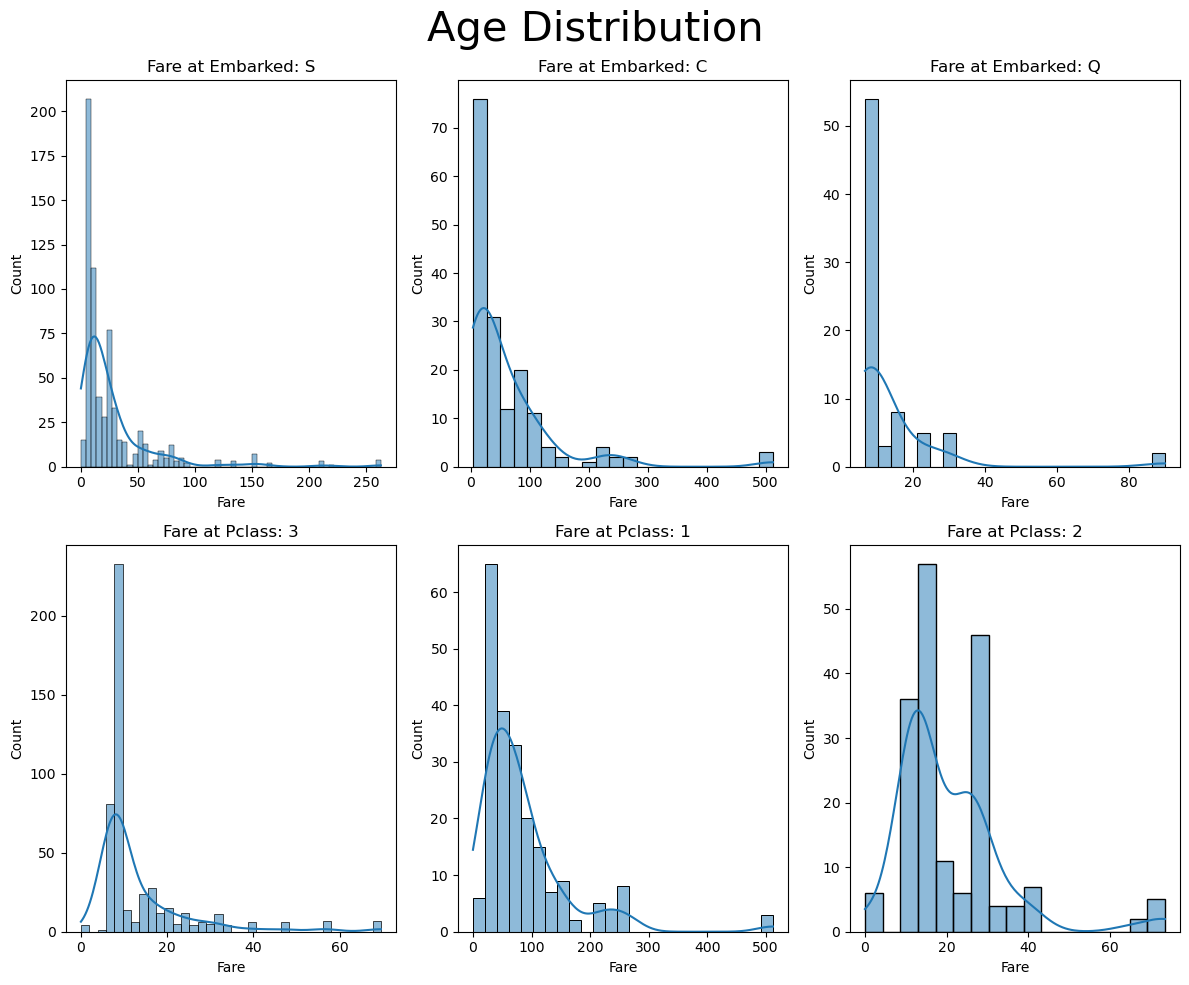

In [109]:
fig, ax = plt.subplots(2,3, figsize=(12,10))

embarked = train["Embarked"].unique()
pclass = train["Pclass"].unique()

for i in range(2):
    for j in range(3):
        if i == 0:
            data = train[train["Embarked"]==embarked[j]]
            sns.histplot(data=data, x="Fare", ax=ax[i,j], kde=True)
            ax[i, j].set_title(f"Fare at Embarked: {embarked[j]}")
        else:
            data = train[train["Pclass"]==pclass[j]]
            sns.histplot(data=data, x="Fare", ax=ax[i,j], kde=True)  
            ax[i, j].set_title(f"Fare at Pclass: {pclass[j]}")
fig.suptitle("Age Distribution", size=30)
fig.tight_layout()
plt.show()